In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder,PowerTransformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE, ADASYN

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 5000)
plt.style.use('seaborn')
%matplotlib inline

In [2]:
train_data = pd.read_csv('C:/Users/user/Desktop/ML marathon/2020-ml100marathon-midterm/train_data.csv')
test_data = pd.read_csv('C:/Users/user/Desktop/ML marathon/2020-ml100marathon-midterm/test_features.csv')
data = pd.concat([train_data, test_data], axis = 0)
print(f'train shape: {train_data.shape}')
print(f'test shape: {test_data.shape}')
print(f'total shape: {data.shape}')
data.reset_index(inplace=True, drop=True)
data.head()

train shape: (113, 22)
test shape: (33, 21)
total shape: (146, 22)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [3]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data, axis):
    data_na = (df_data.isnull().sum(axis = axis) / df_data.shape[axis]) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return missing_data
print(na_check(data, 0))
print()
print(na_check(data, 1)) # 每一筆資料或多或少都有缺值

                           Missing Ratio
loan_advances                  97.260274
director_fees                  88.356164
restricted_stock_deferred      87.671233
deferral_payments              73.287671
deferred_income                66.438356
long_term_incentive            54.794521
bonus                          43.835616
from_this_person_to_poi        41.095890
from_poi_to_this_person        41.095890
from_messages                  41.095890
shared_receipt_with_poi        41.095890
to_messages                    41.095890
other                          36.301370
expenses                       34.931507
salary                         34.931507
exercised_stock_options        30.136986
restricted_stock               24.657534
email_address                  23.972603
poi                            22.602740
total_payments                 14.383562
total_stock_value              13.698630

     Missing Ratio
107      90.909091
79       81.818182
30       81.818182
136      81.818182
65

Note: This summary schedule includes payments to either Debtor or non-debtor employees and non-employee directors made on behalf of a Debtor company.

Definitions of Category Groupings:
1. __Salary__: Reflects items such as base salary, executive cash allowances, and benefits payments.反映基本工資、主管現金津貼和福利支付等項目。
2. __Bonus__: Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.反映根據公司績效支付的年度現金獎勵。還可能包括其他保留金（事情做完才拿的到的錢）。
3. __Long Term Incentive__: Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.長期獎勵計劃（包括給予高層管理者、高級專業技術人員的股票、股票期權、紅利和一般員工的勞動分紅、員工持股計劃等形式。目的是用於促使經營者關註企業的長期發展潛力。）
4. __Deferred Income__: Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors under a deferred compensation arrangement.  May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.遞延收入。反映自願執行主管遞延薪資，年度現金獎勵和長期現金獎勵以及非僱員董事根據遞延薪酬安排遞延的現金費用。也可能反映股票期權或虛擬股票單位下的延期，以代替現金安排。
5. __Deferral Payments__: Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.反映根據計劃規定，由於終止僱傭關係或因在職撤職而產生的遞延補償安排的分配。
6. __Loan Advances__: Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment.  In certain instances, the terms of the promissory notes allow for the option to repay with stock of the company.反映債務人為償還承諾而提供的貸款預付款總額,不包括還款。
7. __Other__: Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e. housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.).  May also include payments provided with respect to employment agreements, as well as imputed income amounts for such things as use of corporate aircraft. 反映了諸如嚴重性付款，諮詢服務，搬遷費用，預支稅款和為國際任務分配給僱員的津貼（例如，住房津貼，生活津貼，根據安然稅收均等計劃進行的付款等）等項目。也可能包括與僱傭協議有關的付款，以及使用公務機之類的估算收入金額。
8. __Expense__: Reflects reimbursements of business expenses. May include fees paid for consulting services.反映了業務費用的報銷。可能包括為諮詢服務支付的費用
9. __Director Fees__: Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors. 反映現金支付和/或股票贈款的價值,代替向非雇員董事支付現金。
10. __Exercised Stock Options__:Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and the timing of any subsequent sale of the securities. 買賣認股權？
11. __Restricted Stock__: Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting periods, regardless of whether deferred.僱主承諾給與員工某個固定額度的限制性股票，員工在工作一定時間後，就會轉移到他的戶頭。這種薪資給付方式，稱為限制性股票單位。
12. __Restricted Stock Deferred__: Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement. 
13. __Stock Value__: In 1998, 1999 and 2000, Debtor and non-debtor affiliates were charged for options granted. The Black-Scholes method was used to determine the amount to be charged.  Any amounts charged to Debtor and non-debtor affiliates associated with the options exercised related to these three years have not been subtracted from the share value amounts shown.

In [4]:
data.columns

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'poi',
       'restricted_stock', 'restricted_stock_deferred', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value'],
      dtype='object')

In [5]:
payment_columns = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                   'loan_advances', 'other', 'expenses', 'director_fees']
stock_columns = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
email_columns = ['email_address', 'from_messages', 'to_messages', 'from_poi_to_this_person', 
                 'from_this_person_to_poi', 'shared_receipt_with_poi']
print(f'payment: {len(payment_columns)}, stock: {len(stock_columns)}, email: {len(email_columns)}')

payment: 9, stock: 4, email: 6


In [6]:
df_payment = data[payment_columns]
df_payment = df_payment.fillna(0)
# BELFER, ROBERT 資料有誤
df_payment.at[50, 'deferred_income'] =  -102500
df_payment.at[50, 'deferral_payments'] =  0
df_payment.at[50, 'expenses'] =  3285
df_payment.at[50, 'director_fees'] =  102500
df_payment['total_payments'] = df_payment['salary'] + df_payment['bonus'] + df_payment['long_term_incentive'] \
                            + df_payment['deferred_income'] + df_payment['deferral_payments'] + df_payment['loan_advances'] \
                            + df_payment['other'] + df_payment['expenses'] + df_payment['director_fees']
df_payment['deferred_income'] = abs(df_payment['deferred_income'])

In [7]:
pd.concat([data.name, df_payment], axis = 1).sort_values(by = 'name')

,name,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
14,ALLEN PHILLIP K,201955.0,4175000.0,304805.0,3081055.0,2869717.0,0.0,152.0,13868.0,0.0,4484442.0
92,BADUM JAMES P,0.0,0.0,0.0,0.0,178980.0,0.0,0.0,3486.0,0.0,182466.0
95,BANNANTINE JAMES M,477.0,0.0,0.0,5104.0,0.0,0.0,864523.0,56301.0,0.0,916197.0
58,BAXTER JOHN C,267102.0,1200000.0,1586055.0,1386055.0,1295738.0,0.0,2660303.0,11200.0,0.0,5634343.0
131,BAY FRANKLIN R,239671.0,400000.0,0.0,201641.0,260455.0,0.0,69.0,129142.0,0.0,827696.0
40,BAZELIDES PHILIP J,80818.0,0.0,93750.0,0.0,684694.0,0.0,874.0,0.0,0.0,860136.0
63,BECK SALLY W,231330.0,700000.0,0.0,0.0,0.0,0.0,566.0,37172.0,0.0,969068.0
113,BELDEN TIMOTHY N,213999.0,5249999.0,0.0,2334434.0,2144013.0,0.0,210698.0,17355.0,0.0,5501630.0
50,BELFER ROBERT,0.0,0.0,0.0,102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0
55,BERBERIAN DAVID,216582.0,0.0,0.0,0.0,0.0,0.0,0.0,11892.0,0.0,228474.0


(146, 10)


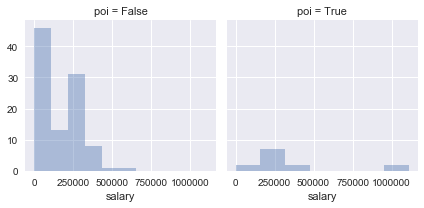

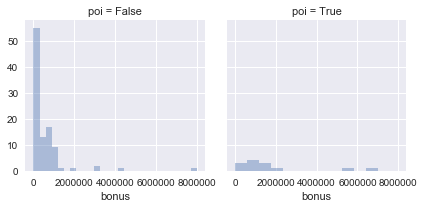

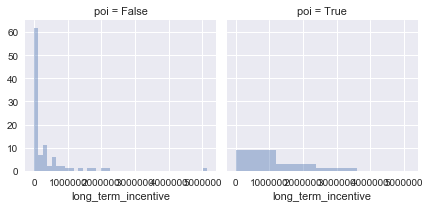

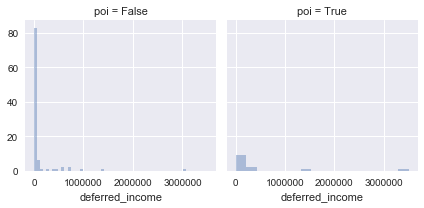

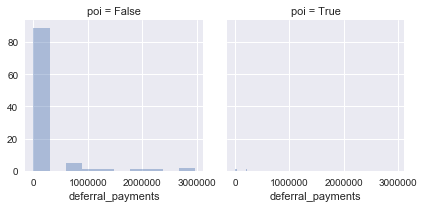

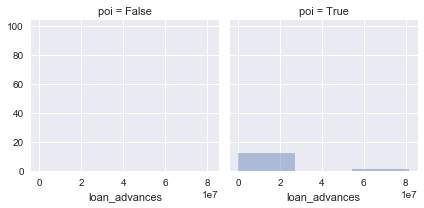

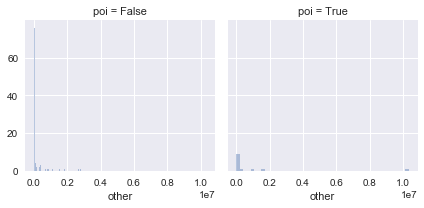

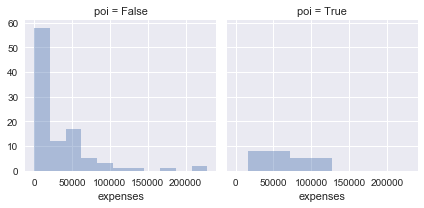

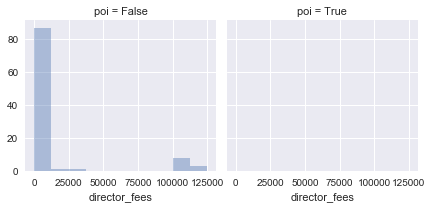

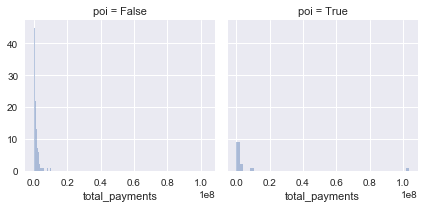

In [8]:
print(df_payment.shape)
for feature, dtype in zip(df_payment.columns, df_payment.dtypes):
    if dtype == 'float64':
        g = sns.FacetGrid(pd.concat([df_payment, data.poi], axis = 1), col = 'poi')
        g.map(sns.distplot, feature, kde = False)

In [9]:
df_stock = data[stock_columns]
df_stock = df_stock.fillna(0)

# BELFER, ROBERT 資料有誤
df_stock.at[50, 'exercised_stock_options'] =  0
df_stock.at[50, 'restricted_stock'] =  44093
df_stock.at[50, 'restricted_stock_deferred'] =  -44093
df_stock.at[50, 'total_stock_value'] =  0
# BHATNAGAR SANJAY 資料有誤
df_stock.at[139, 'exercised_stock_options'] =  15456290.0
df_stock.at[139, 'restricted_stock'] =  2604490.0
df_stock.at[139, 'restricted_stock_deferred'] =  -2604490.0
df_stock.at[139, 'total_stock_value'] =  15456290.0

# 檢查股價總和
for i in range(len(df_stock)):
    if np.sum(df_stock.iloc[i,:3]) != df_stock['total_stock_value'][i]:
        print(data.name[i])

# 增加特徵
df_stock['exercised_ratio'] = df_stock['exercised_stock_options'] / df_stock['total_stock_value']
df_stock['restricted_ratio'] = df_stock['restricted_stock'] / df_stock['total_stock_value']
df_stock['restricted_stock_deferred'] = abs(df_stock['restricted_stock_deferred'])
df_stock.replace(np.inf, 0, inplace = True)
df_stock = df_stock.fillna(0)

pd.concat([data.name, df_stock], axis = 1)

,name,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,exercised_ratio,restricted_ratio
0,RICE KENNETH D,19794175.0,2748364.0,0.0,22542539.0,0.878081,0.121919
1,SKILLING JEFFREY K,19250000.0,6843672.0,0.0,26093672.0,0.737727,0.262273
2,SHELBY REX,1624396.0,869220.0,0.0,2493616.0,0.651422,0.348578
3,KOPPER MICHAEL J,0.0,985032.0,0.0,985032.0,0.000000,1.000000
4,CALGER CHRISTOPHER F,0.0,126027.0,0.0,126027.0,0.000000,1.000000
5,HIRKO JOSEPH,30766064.0,0.0,0.0,30766064.0,1.000000,0.000000
6,YEAGER F SCOTT,8308552.0,3576206.0,0.0,11884758.0,0.699093,0.300907
7,COLWELL WESLEY,0.0,698242.0,0.0,698242.0,0.000000,1.000000
8,LAY KENNETH L,34348384.0,14761694.0,0.0,49110078.0,0.699416,0.300584
9,GLISAN JR BEN F,384728.0,393818.0,0.0,778546.0,0.494162,0.505838


(146, 6)


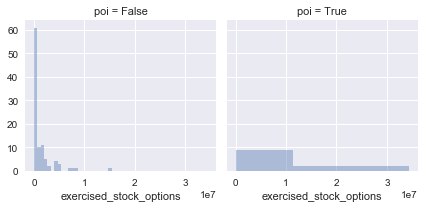

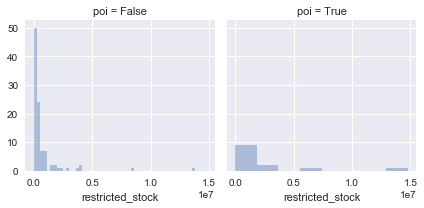

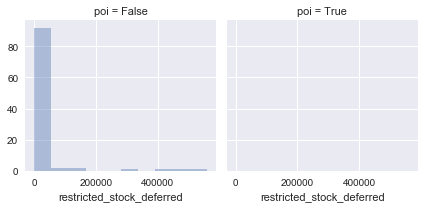

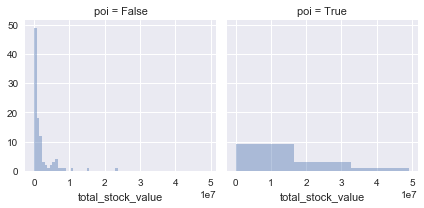

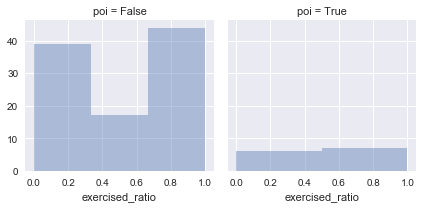

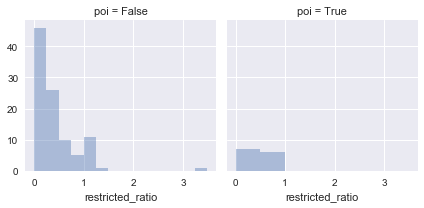

In [10]:
print(df_stock.shape)
for feature, dtype in zip(df_stock.columns, df_stock.dtypes):
    if dtype == 'float64':
        g = sns.FacetGrid(pd.concat([df_stock, data.poi], axis = 1), col = 'poi')
        g.map(sns.distplot, feature, kde = False)

In [11]:
df_email = data[email_columns]
df_email = df_email.fillna(0)
df_email['from_poi_ratio'] = df_email['from_poi_to_this_person'] / (df_email['from_messages'] + df_email['from_poi_to_this_person'])
df_email['to_poi_ratio'] = df_email['from_this_person_to_poi'] / (df_email['to_messages'] + df_email['from_this_person_to_poi'])
df_email['poi_interact_ratio'] = (df_email['from_this_person_to_poi'] + df_email['from_poi_to_this_person']) \
                               / (df_email['from_this_person_to_poi'] + df_email['from_poi_to_this_person'] \
                                + df_email['from_messages'] + df_email['to_messages'])
df_email['poi_receipt_ratio'] = df_email['shared_receipt_with_poi'] / (df_email['from_this_person_to_poi'] \
                              + df_email['from_poi_to_this_person'] + df_email['from_messages'] + df_email['to_messages'])
df_email = df_email.fillna(0)

pd.concat([data.name, df_email], axis = 1)

,name,email_address,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio
0,RICE KENNETH D,ken.rice@enron.com,18.0,905.0,42.0,4.0,864.0,0.700000,0.004400,0.047472,0.891641
1,SKILLING JEFFREY K,jeff.skilling@enron.com,108.0,3627.0,88.0,30.0,2042.0,0.448980,0.008203,0.030625,0.529977
2,SHELBY REX,rex.shelby@enron.com,39.0,225.0,13.0,14.0,91.0,0.250000,0.058577,0.092784,0.312715
3,KOPPER MICHAEL J,michael.kopper@enron.com,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,CALGER CHRISTOPHER F,christopher.calger@enron.com,144.0,2598.0,199.0,25.0,2188.0,0.580175,0.009531,0.075523,0.737694
5,HIRKO JOSEPH,joe.hirko@enron.com,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,YEAGER F SCOTT,scott.yeager@enron.com,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7,COLWELL WESLEY,wes.colwell@enron.com,40.0,1758.0,240.0,11.0,1132.0,0.857143,0.006218,0.122499,0.552465
8,LAY KENNETH L,kenneth.lay@enron.com,36.0,4273.0,123.0,16.0,2411.0,0.773585,0.003730,0.031250,0.542041
9,GLISAN JR BEN F,ben.glisan@enron.com,16.0,873.0,52.0,6.0,874.0,0.764706,0.006826,0.061246,0.922914


In [12]:
print(df_email['from_poi_to_this_person'].sum(axis = 0))
print(df_email['from_this_person_to_poi'].sum(axis = 0))
print(df_email['shared_receipt_with_poi'].sum(axis = 0))

5581.0
3546.0
101176.0


(146, 10)


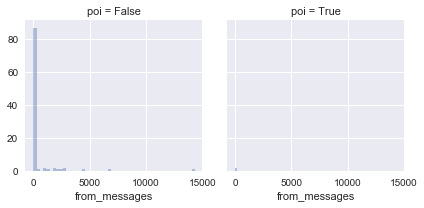

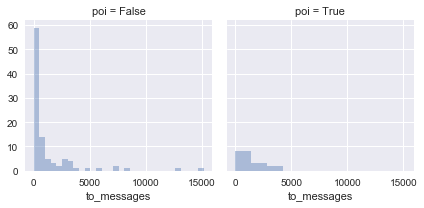

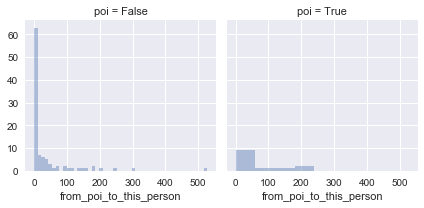

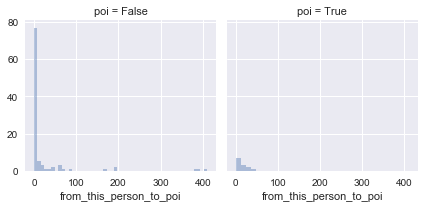

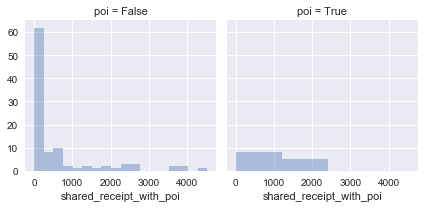

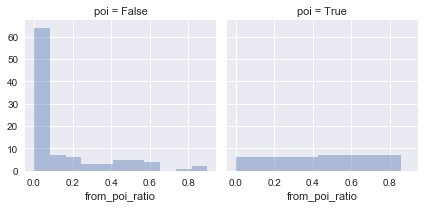

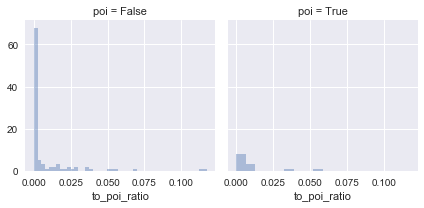

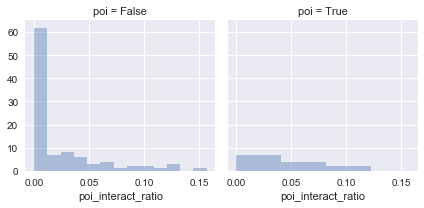

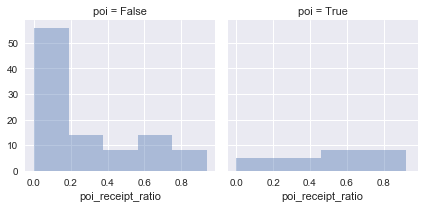

In [13]:
print(df_email.shape)
for feature, dtype in zip(df_email.columns, df_email.dtypes):
    if dtype == 'float64':
        g = sns.FacetGrid(pd.concat([df_email, data.poi], axis = 1), col = 'poi')
        g.map(sns.distplot, feature, kde = False)

In [16]:
df = pd.concat([df_payment, df_stock, df_email], axis = 1)
df['total_value'] = df['total_payments'] + df['total_stock_value']
df = df.drop('email_address', axis = 1)
df = df.drop('loan_advances' ,axis = 1)
df.shape

(146, 25)

In [17]:
pd.concat([data.name, df], axis = 1).sort_values(by = 'name')

,name,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,total_payments,...,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio,total_value
14,ALLEN PHILLIP K,201955.0,4175000.0,304805.0,3081055.0,2869717.0,152.0,13868.0,0.0,4484442.0,...,2195.0,2902.0,47.0,65.0,1407.0,0.020963,0.021908,0.021501,0.270109,6213983.0
92,BADUM JAMES P,0.0,0.0,0.0,0.0,178980.0,0.0,3486.0,0.0,182466.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,440283.0
95,BANNANTINE JAMES M,477.0,0.0,0.0,5104.0,0.0,864523.0,56301.0,0.0,916197.0,...,29.0,566.0,39.0,0.0,465.0,0.573529,0.000000,0.061514,0.733438,6159684.0
58,BAXTER JOHN C,267102.0,1200000.0,1586055.0,1386055.0,1295738.0,2660303.0,11200.0,0.0,5634343.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,16257601.0
131,BAY FRANKLIN R,239671.0,400000.0,0.0,201641.0,260455.0,69.0,129142.0,0.0,827696.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,890710.0
40,BAZELIDES PHILIP J,80818.0,0.0,93750.0,0.0,684694.0,874.0,0.0,0.0,860136.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2459777.0
63,BECK SALLY W,231330.0,700000.0,0.0,0.0,0.0,566.0,37172.0,0.0,969068.0,...,4343.0,7315.0,144.0,386.0,2639.0,0.032093,0.050123,0.043485,0.216524,1095095.0
113,BELDEN TIMOTHY N,213999.0,5249999.0,0.0,2334434.0,2144013.0,210698.0,17355.0,0.0,5501630.0,...,484.0,7991.0,228.0,108.0,5521.0,0.320225,0.013335,0.038134,0.626603,6612335.0
50,BELFER ROBERT,0.0,0.0,0.0,102500.0,0.0,0.0,3285.0,102500.0,3285.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3285.0
55,BERBERIAN DAVID,216582.0,0.0,0.0,0.0,0.0,0.0,11892.0,0.0,228474.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2722090.0


In [18]:
data[:13]

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0
5,HIRKO JOSEPH,NaN,10259.0,NaN,NaN,joe.hirko@enron.com,30766064.0,77978.0,NaN,NaN,...,NaN,2856.0,True,NaN,NaN,NaN,NaN,NaN,91093.0,30766064.0
6,YEAGER F SCOTT,NaN,NaN,NaN,NaN,scott.yeager@enron.com,8308552.0,53947.0,NaN,NaN,...,NaN,147950.0,True,3576206.0,NaN,158403.0,NaN,NaN,360300.0,11884758.0
7,COLWELL WESLEY,1200000.0,27610.0,-144062.0,NaN,wes.colwell@enron.com,NaN,16514.0,40.0,240.0,...,NaN,101740.0,True,698242.0,NaN,288542.0,1132.0,1758.0,1490344.0,698242.0
8,LAY KENNETH L,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,...,3600000.0,10359729.0,True,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
9,GLISAN JR BEN F,600000.0,NaN,NaN,NaN,ben.glisan@enron.com,384728.0,125978.0,16.0,52.0,...,71023.0,200308.0,True,393818.0,NaN,274975.0,874.0,873.0,1272284.0,778546.0


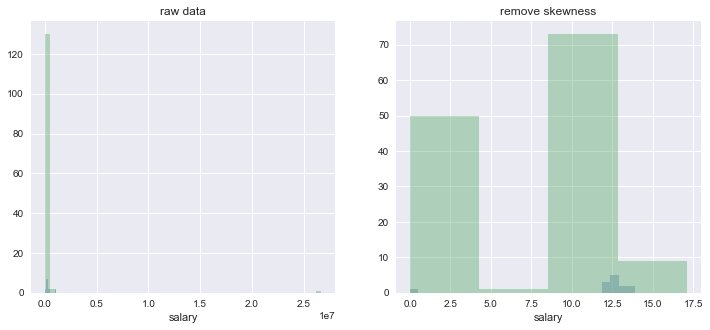

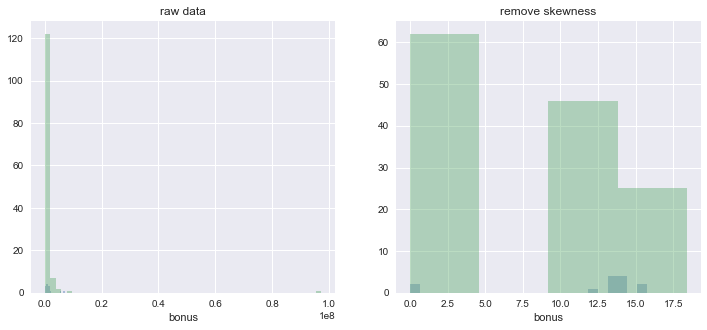

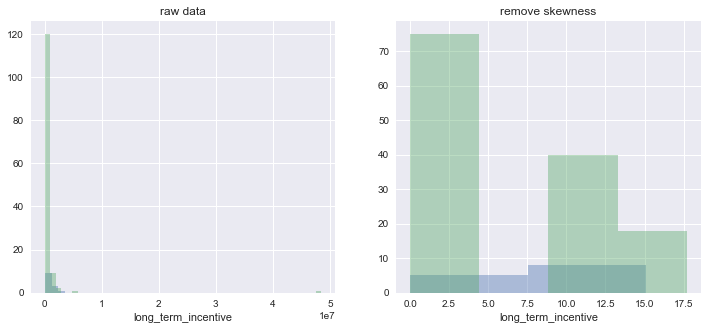

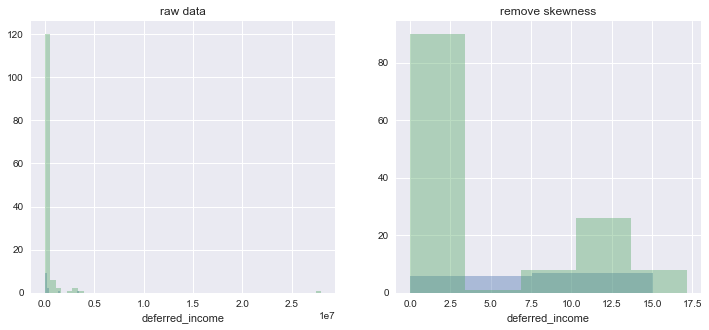

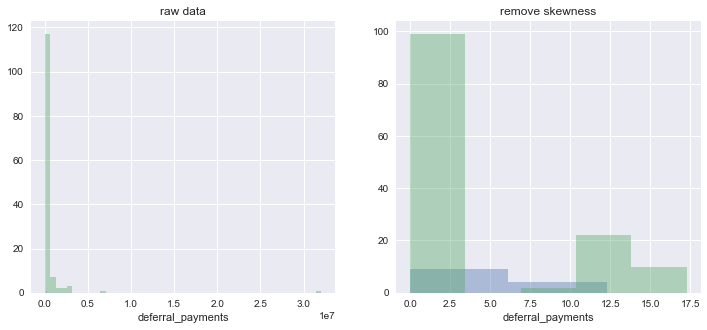

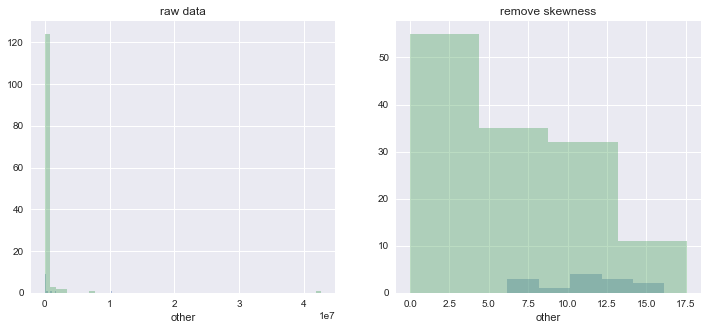

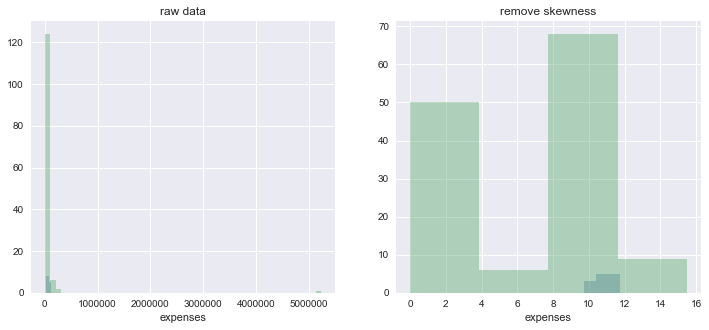

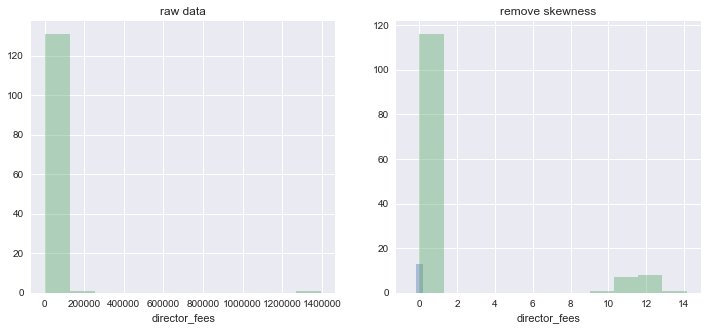

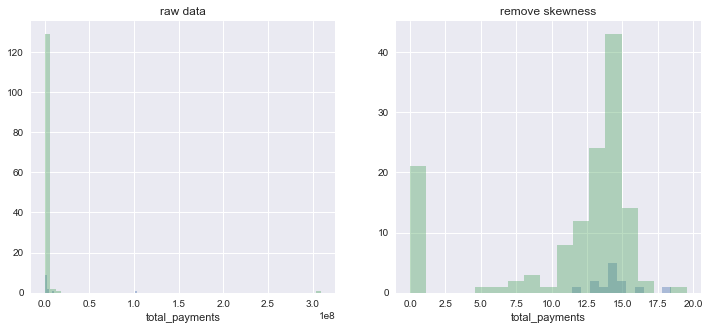

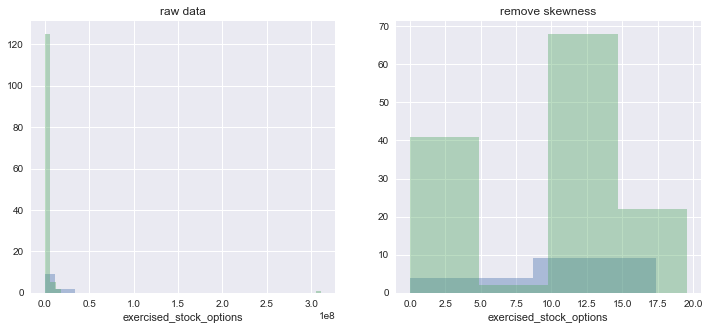

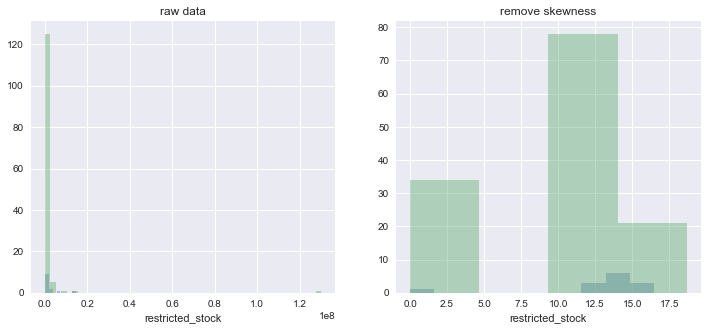

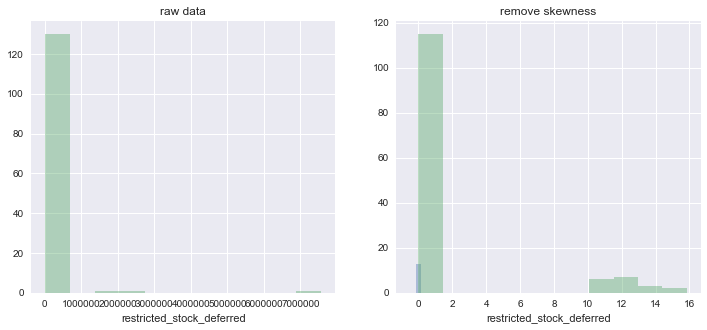

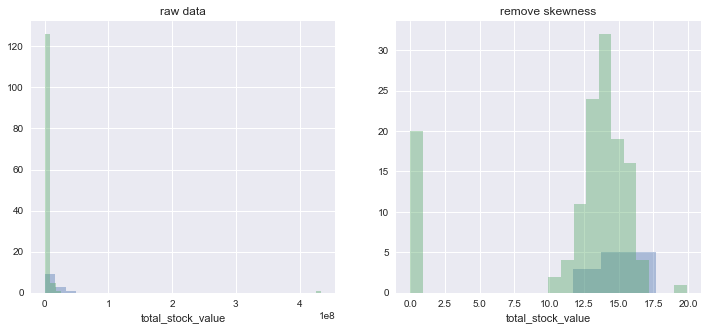

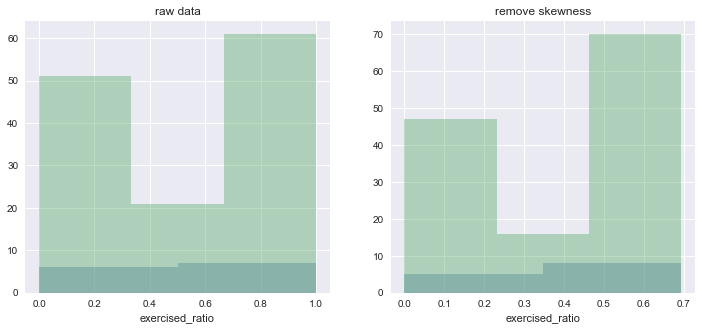

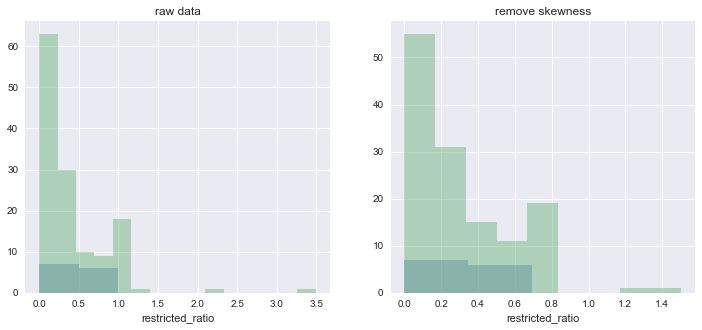

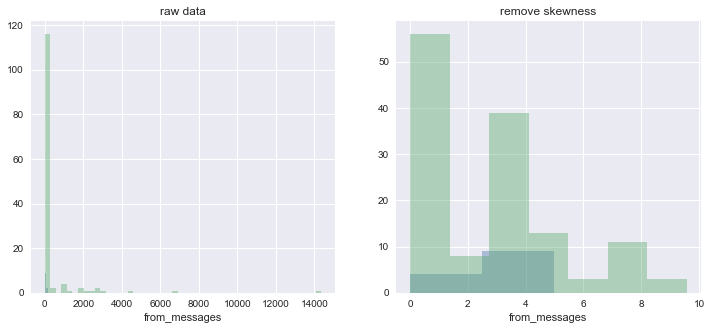

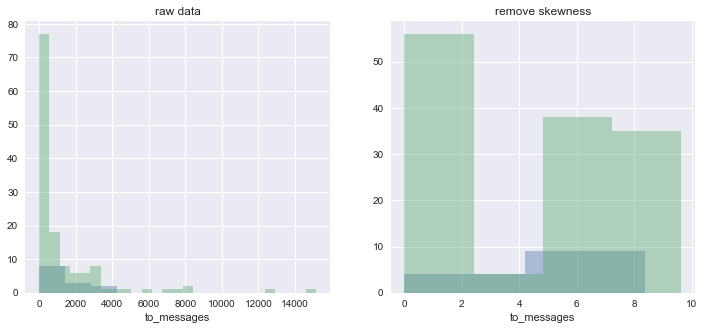

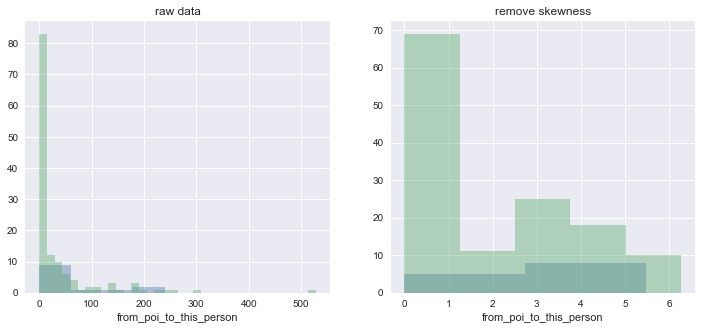

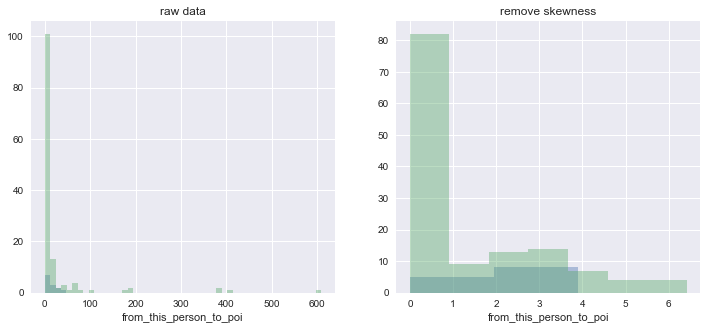

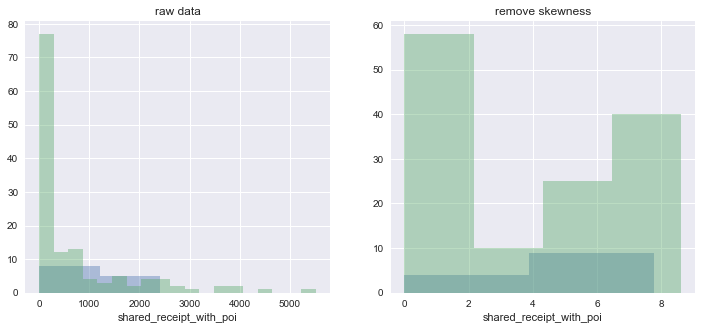

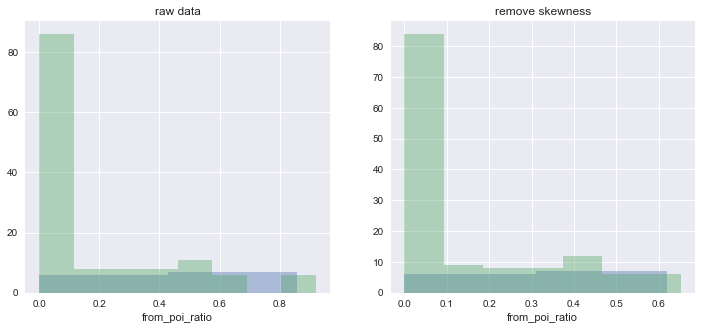

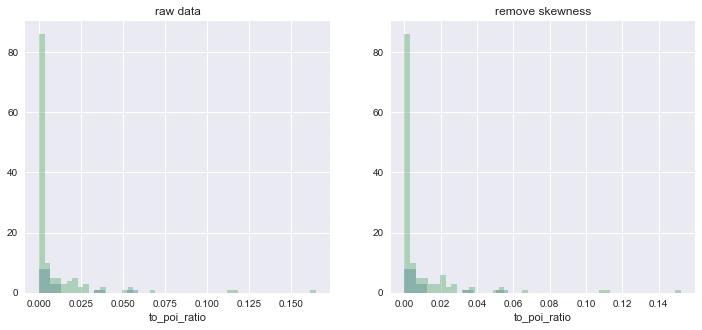

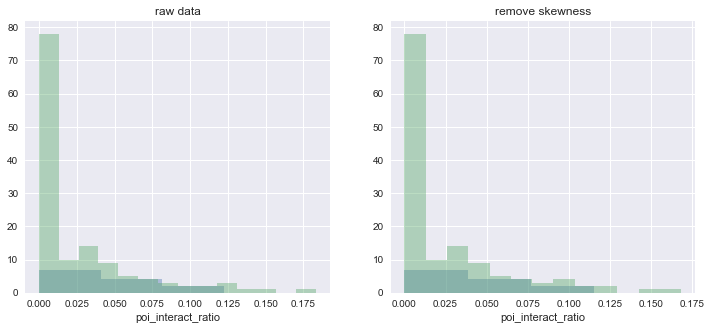

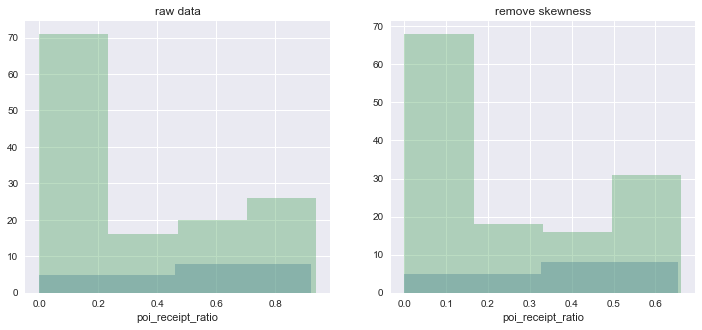

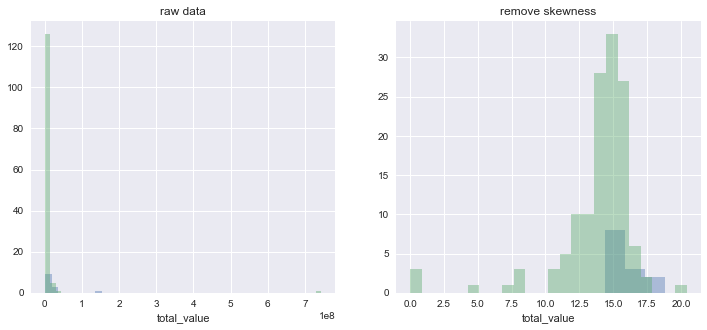

In [19]:
for feature, dtype in zip(df.columns, df.dtypes):
    if dtype == 'float64':
        plt.figure(figsize = (12, 5))
        plt.subplot(1, 2, 1)
        sns.distplot(df[feature][:13], kde = False)
        sns.distplot(df[feature][13:], kde = False)
        plt.title('raw data')
        
        plt.subplot(1, 2, 2)
        sns.distplot(np.log1p(df[feature][:13]), kde = False)
        sns.distplot(np.log1p(df[feature][13:]), kde = False)
        plt.title('remove skewness')
        plt.show()

In [20]:
numeric_features = df.dtypes[df.dtypes != "object"].index
skew_of_features = df[numeric_features].apply(lambda x: skew(x, nan_policy = 'omit')).sort_values(ascending=False)
print(skew_of_features)

salary                       11.815934
expenses                     11.763762
bonus                        11.556155
long_term_incentive          11.462467
total_stock_value            11.447317
restricted_stock             11.388087
exercised_stock_options      11.353041
total_value                  11.197726
deferred_income              10.880782
deferral_payments            10.735944
director_fees                10.726690
other                        10.503139
total_payments               10.473707
restricted_stock_deferred     9.666364
from_messages                 7.261995
from_this_person_to_poi       5.075820
to_poi_ratio                  4.218867
to_messages                   3.458344
from_poi_to_this_person       3.260903
restricted_ratio              2.633318
shared_receipt_with_poi       1.949321
poi_interact_ratio            1.755494
from_poi_ratio                1.208250
poi_receipt_ratio             0.506005
exercised_ratio              -0.191748
dtype: float64


In [21]:
high_skewness = skew_of_features[abs(skew_of_features.values) > 0.9]
skewed_features = high_skewness.index
print(skewed_features)

Index(['salary', 'expenses', 'bonus', 'long_term_incentive',
       'total_stock_value', 'restricted_stock', 'exercised_stock_options',
       'total_value', 'deferred_income', 'deferral_payments', 'director_fees',
       'other', 'total_payments', 'restricted_stock_deferred', 'from_messages',
       'from_this_person_to_poi', 'to_poi_ratio', 'to_messages',
       'from_poi_to_this_person', 'restricted_ratio',
       'shared_receipt_with_poi', 'poi_interact_ratio', 'from_poi_ratio'],
      dtype='object')


In [22]:
df_ = df.copy()
for feature in skewed_features:
    df_[feature] = boxcox1p(df_[feature], boxcox_normmax(df_[feature] + 1))

In [23]:
df_ # 去偏態後的資料

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,total_payments,exercised_stock_options,...,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio,total_value
0,78.761186,106.568168,91.880213,43.051749,0.000000,18.496190,40.896306,0.000000,53.275984,135.197658,...,2.850966,23.840678,5.379987,1.451100,23.497969,0.336097,0.003546,0.030091,0.891641,75.849812
1,99.264577,139.514452,95.443097,0.000000,0.000000,14.195410,36.598626,0.000000,92.485731,134.426514,...,4.457043,38.600297,6.910786,2.765500,31.778601,0.267235,0.005561,0.022581,0.529977,81.018426
2,66.777588,63.926871,0.000000,14.416353,0.000000,23.761612,34.494555,0.000000,69.793716,80.481770,...,3.542957,14.288607,3.379081,2.279819,10.003863,0.182336,0.009860,0.041226,0.312715,58.153915
3,67.706504,88.754870,73.728105,0.000000,0.000000,22.370069,50.670290,0.000000,73.685088,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.153292
4,68.834418,98.528064,66.270549,29.213568,0.000000,7.650658,38.371280,0.000000,67.125253,0.000000,...,4.713597,34.444196,8.868089,2.652026,32.545890,0.307139,0.006100,0.038104,0.737694,49.787886
5,0.000000,0.000000,0.000000,0.000000,17.120893,10.480024,46.035035,0.000000,37.699937,147.980665,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.483668
6,62.234952,0.000000,0.000000,0.000000,0.000000,18.126478,42.249323,0.000000,49.814421,113.071100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.490908
7,71.945861,97.593078,0.000000,26.583860,20.376123,17.312183,31.892782,0.000000,65.892697,0.000000,...,3.565716,30.102039,9.360797,2.121007,25.861607,0.366213,0.004606,0.044667,0.552465,51.609712
8,98.429208,146.873492,109.641274,29.825311,28.262128,28.931728,48.743019,0.000000,147.441653,151.350959,...,3.471019,40.807237,7.678133,2.366887,33.652822,0.351155,0.003103,0.022908,0.542041,102.425077
9,71.116294,82.952191,45.250110,0.000000,0.000000,18.800307,51.424528,0.000000,63.891861,59.277967,...,2.746599,23.537168,5.799642,1.717695,23.594595,0.349433,0.004919,0.034585,0.922914,51.052527


In [ ]:
df = train_data.copy()
plt.scatter(df.other, df.poi)
plt.xlabel('other')
plt.ylabel('poi')
plt.show()

train_data[train_data.other == np.max(train_data.other)] # 將這個人的資料裁切到 99 百分位

df['other'] = df['other'].replace(train_data.other.max(), train_data.other.quantile(0.98))
plt.scatter(df.other, df.poi)
plt.xlabel('other')
plt.ylabel('poi')
plt.show()

In [ ]:
df = train_data.copy()
plt.scatter(df['expenses'], df['poi'])
plt.xlabel('expenses')
plt.ylabel('poi')
plt.show()

df['expenses'] = df['expenses'].clip(df['expenses'].min(), df['expenses'].quantile(0.95))
   
plt.scatter(df['expenses'], df['poi'])
plt.xlabel('expenses')
plt.ylabel('poi')
plt.show()

In [ ]:
df = train_data.copy()
plt.scatter(df['exercised_stock_options'], df['poi'])
plt.xlabel('exercised_stock_options')
plt.ylabel('poi')
plt.show()

df['exercised_stock_options'] = df['exercised_stock_options'].clip(df['exercised_stock_options'].min(), df['exercised_stock_options'].quantile(0.96))

plt.scatter(df['exercised_stock_options'], df['poi'])
plt.xlabel('exercised_stock_options')
plt.ylabel('poi')
plt.show()

In [ ]:
df = train_data.copy()
plt.scatter(df['total_stock_value'], df['poi'])
plt.xlabel('total_stock_value')
plt.ylabel('poi')
plt.show()

df['total_stock_value'] = df['total_stock_value'].clip(df['total_stock_value'].min(), df['total_stock_value'].quantile(0.99))

plt.scatter(df['total_stock_value'], df['poi'])
plt.xlabel('total_stock_value')
plt.ylabel('poi')
plt.show()

In [ ]:
df = train_data.copy()
plt.scatter(df['from_messages'], df['poi'])
plt.xlabel('from_messages')
plt.ylabel('poi')
plt.show()

df['from_messages'] = df['from_messages'].clip(df['from_messages'].min(), df['from_messages'].quantile(0.95))

plt.scatter(df['from_messages'], df['poi'])
plt.xlabel('from_messages')
plt.ylabel('poi')
plt.show()

In [ ]:
df = train_data.copy()
plt.scatter(df['total_payments'], df['poi'])
plt.xlabel('total_payments')
plt.ylabel('poi')
plt.show()

df['total_payments'] = df['total_payments'].clip(df['total_payments'].min(), df['total_payments'].quantile(0.98))

plt.scatter(df['total_payments'], df['poi'])
plt.xlabel('total_payments')
plt.ylabel('poi')
plt.show()

In [39]:
def model_selection(x, y, cv):
    # NAIBE BAYES
    from sklearn.naive_bayes import GaussianNB

    nb_model = GaussianNB()
    nb_score = cross_val_score(nb_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Naive Bayes: {nb_score.mean()} \u00B1 {nb_score.std()}')

    #KNN
    from sklearn.neighbors import KNeighborsClassifier

    knn_model = KNeighborsClassifier(n_neighbors = 5)
    knn_score = cross_val_score(knn_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'KNN: {knn_score.mean()} \u00B1 {knn_score.std()}')

    #RANDOM FOREST
    from sklearn.ensemble import RandomForestClassifier

    rfc_model = RandomForestClassifier(n_estimators = 100,random_state = 99)
    rfc_score = cross_val_score(rfc_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Random Forest: {rfc_score.mean()} \u00B1 {rfc_score.std()}')

    #LOGISTIC REGRESSION
    from sklearn.linear_model import LogisticRegression

    lr_model = LogisticRegression(solver = 'saga')
    lr_score = cross_val_score(lr_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Logistic Regression: {lr_score.mean()} \u00B1 {lr_score.std()}')

    #SVM
    from sklearn.svm import SVC

    svc_model = SVC(gamma = 'auto')
    svc_score = cross_val_score(svc_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'SVM: {svc_score.mean()} \u00B1 {svc_score.std()}')

    #DECISON TREE
    from sklearn.tree import DecisionTreeClassifier

    dtree_model = DecisionTreeClassifier()
    dtree_score = cross_val_score(dtree_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Decision Tree: {dtree_score.mean()} \u00B1 {dtree_score.std()}')

    #XGBOOST
    from xgboost import XGBClassifier

    xgb = XGBClassifier()
    xgb_score = cross_val_score(xgb, x, y, cv = cv, scoring = 'roc_auc')
    print(f'XGBoost: {xgb_score.mean()} \u00B1 {xgb_score.std()}')

In [45]:
# SMOTE
# 透過 SMOTE(Synthetic Minority Oversampling Technique)技術，
# 將不平衡的 POI Label 調整為 True :Fales = 1:1  

sm = SMOTE(random_state=4)
data_0 = data.drop(['name', 'poi', 'email_address'], axis = 1).fillna(0)
train_num = train_data.shape[0]
train_data_res,train_Y_res = sm.fit_resample(df_[:train_num], data['poi'][:train_num].astype('int'))
train_data_res = pd.DataFrame(train_data_res,columns = df_.columns)
# train_data_res

x = train_data_res
y = train_Y_res
print(f'x shape: {x.shape}')

model_selection(x, y, 10)

x shape: (200, 25)
Naive Bayes: 0.916 ± 0.05799999999999997
KNN: 0.9295 ± 0.060969254546861563
Random Forest: 0.998 ± 0.0040000000000000036
Logistic Regression: 0.885 ± 0.062169124169478195
SVM: 0.96 ± 0.030413812651491085
Decision Tree: 0.8899999999999999 ± 0.06999999999999999
XGBoost: 0.992 ± 0.013266499161421575


In [60]:
# 使用原始資料直接訓練
train_num = train_data.shape[0]
data_0 = data.drop(['name', 'poi', 'email_address'], axis = 1).fillna(0)
x = data_0[:train_num]
y = data['poi'][:train_num].astype('int')
print(f'x shape: {x.shape}')

# model training
model_selection(x, y, 10)

x shape: (113, 19)
Naive Bayes: 0.79 ± 0.2736786436680802
KNN: 0.7424999999999999 ± 0.2655301301170924
Random Forest: 0.7575000000000001 ± 0.20556325060671712
Logistic Regression: 0.175 ± 0.1364734406395618
SVM: 0.5 ± 0.0
Decision Tree: 0.6250000000000001 ± 0.22276669409945465
XGBoost: 0.8450000000000001 ± 0.1386542462386205


In [47]:
# 使用原始資料加上'特徵組合'再訓練
train_num = train_data.shape[0]
x = df[:train_num]
y = data['poi'][:train_num].astype('int')
print(f'x shape: {x.shape}')

# model training
model_selection(x, y, 10)

x shape: (113, 25)
Naive Bayes: 0.885 ± 0.155
KNN: 0.725 ± 0.2839454172900137
Random Forest: 0.75 ± 0.2280350850198276
Logistic Regression: 0.145 ± 0.12338962679253067
SVM: 0.5 ± 0.0
Decision Tree: 0.5850000000000001 ± 0.21219095173922947
XGBoost: 0.8300000000000001 ± 0.22045407685048604


In [63]:
# 使用原始資料加上'特徵組合'，去偏態後再訓練
train_num = train_data.shape[0]
x = df_[:train_num]
y = data['poi'][:train_num].astype('int')
print(f'x shape: {x.shape}')

# model training
model_selection(x, y, 10)

x shape: (113, 25)
Naive Bayes: 0.8450000000000001 ± 0.1588238017426859
KNN: 0.615 ± 0.23350588857671237
Random Forest: 0.7675 ± 0.2269498843357273
Logistic Regression: 0.5900000000000001 ± 0.266270539113887
SVM: 0.55 ± 0.161245154965971
Decision Tree: 0.635 ± 0.2168524844220144
XGBoost: 0.825 ± 0.221641602593015


In [64]:
# 測試特徵重要性
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
rfc_model.fit(x_train, y_train)
FI = pd.DataFrame({'feature':x.columns, 'importance':rfc_model.feature_importances_}).sort_values(by = 'importance', ascending = False)
FI

,feature,importance
9,exercised_stock_options,0.109968
12,total_stock_value,0.093578
24,total_value,0.088014
23,poi_receipt_ratio,0.057607
6,expenses,0.056145
5,other,0.050199
20,from_poi_ratio,0.050110
0,salary,0.042759
2,long_term_incentive,0.041779
22,poi_interact_ratio,0.041715


shape of x: (113, 1) Random Forest: 0.61 ± 0.29878922336657326
shape of x: (113, 2) Random Forest: 0.7200000000000001 ± 0.25317977802344327
shape of x: (113, 3) Random Forest: 0.7525 ± 0.22429054817356886
shape of x: (113, 4) Random Forest: 0.7875000000000001 ± 0.21600057870292846
shape of x: (113, 5) Random Forest: 0.7975000000000001 ± 0.17408690358553686
shape of x: (113, 6) Random Forest: 0.8150000000000001 ± 0.15008331019803636
shape of x: (113, 7) Random Forest: 0.8525 ± 0.14162009038268547
shape of x: (113, 8) Random Forest: 0.8174999999999999 ± 0.1796002505566181
shape of x: (113, 9) Random Forest: 0.7775000000000001 ± 0.1925
shape of x: (113, 10) Random Forest: 0.7975 ± 0.15750000000000003
shape of x: (113, 11) Random Forest: 0.7775000000000001 ± 0.24810532037826194
shape of x: (113, 12) Random Forest: 0.7799999999999999 ± 0.23473389188611007
shape of x: (113, 13) Random Forest: 0.7925 ± 0.2377104330903463
shape of x: (113, 14) Random Forest: 0.8225 ± 0.17764078923490517
shape 

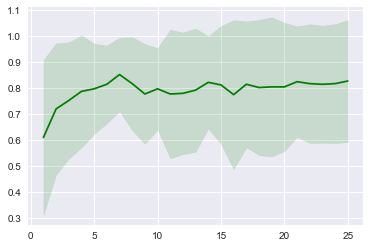

In [65]:
_mean = np.empty(25)
_std = np.empty(25)

for i in range(25):
    x = df_[FI.feature[:i+1]][:train_num]
    y = data['poi'][:train_num].astype('int')
    print(f'shape of x: {x.shape}', end = ' ')

    #RANDOM FOREST
    rfc_model = RandomForestClassifier(n_estimators = 100,random_state = 42)
    rfc_score = cross_val_score(rfc_model, x, y, cv = 10, scoring = 'roc_auc')
    _mean[i] = rfc_score.mean()
    _std[i] = rfc_score.std()
    print(f'Random Forest: {rfc_score.mean()} \u00B1 {rfc_score.std()}')
plt.plot(range(1, 26), _mean, color = 'g')
plt.fill_between(range(1, 26), _mean + _std, _mean - _std, alpha = 0.15, color = 'green')

In [66]:
# 缺值補 -1，直接拿下去 train
# 以 xgboost 做特徵選擇

train_num = train_data.shape[0]
data_0 = data.drop(['name', 'poi', 'email_address'], axis = 1).fillna(0)
x = df_[FI.feature[:7]][:train_num] # df_ 加上幾個新特徵後，去偏態
#x = df[:train_num]     # 加上幾個新特徵
#x = data_0[:train_num] # 原資料集的資料，空值補 0
y = data['poi'][:train_num].astype('int')
print(f'shape of x: {x.shape}')

model_selection(x, y, 10)

shape of x: (113, 7)
Naive Bayes: 0.9200000000000002 ± 0.05567764362830021
KNN: 0.6425 ± 0.2898383169975978
Random Forest: 0.8575000000000002 ± 0.12351619327035625
Logistic Regression: 0.74 ± 0.19078784028338913
SVM: 0.6000000000000001 ± 0.23237900077244503
Decision Tree: 0.605 ± 0.18634645153584228
XGBoost: 0.8399999999999999 ± 0.16852299546352717


In [69]:
# 選幾個比較強的模型

#RANDOM FOREST
rfc_model = RandomForestClassifier(random_state = 42)
# USING GRID SEARCH
n_estimators = [10, 50, 100]
max_depth = [3, 5, 7]
min_samples_leaf = [1, 2, 3]
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
grid_search_rfc = GridSearchCV(estimator = rfc_model, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
rfc_score = cross_val_score(grid_search_rfc.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('Random Forest Best Parmas',grid_search_rfc.best_params_)
print(f'Random Forest Best Score: {rfc_score.mean()} \u00B1 {rfc_score.std()}')

#Naive Bayes
nb_model = GaussianNB()
# USING GRID SEARCH
var_smoothing= [1e-9, 1e-8, 1e-7, 1e-6]
param_grid = dict(var_smoothing = var_smoothing)
grid_search_nb = GridSearchCV(estimator = nb_model, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
nb_score = cross_val_score(grid_search_nb.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('NB Best Parmas',grid_search_nb.best_params_)
print(f'NB Best Score: {nb_score.mean()} \u00B1 {nb_score.std()}')

# XGB
xgb = XGBClassifier(random_state = 42)
# USING GRID SEARCH
learning_rate = [0.001, 0.01, 0.1, 1, 10]
max_depth = [1, 3, 5, 7, 10, 20]
param_grid = dict(learning_rate = learning_rate, max_depth = max_depth)
grid_search_xgb = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
xgb_score = cross_val_score(grid_search_xgb.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('XGB Best Parmas',grid_search_xgb.best_params_)
print(f'XGB Best Score: {xgb_score.mean()} \u00B1 {xgb_score.std()}')

Random Forest Best Parmas {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
Random Forest Best Score: 0.875 ± 0.14008925726121899
KNN Best Parmas {'var_smoothing': 1e-09}
KNN Best Score: 0.9099999999999999 ± 0.07348469228349531
XGB Best Parmas {'learning_rate': 1, 'max_depth': 1}
XGB Best Score: 0.8550000000000001 ± 0.11715374513859983


待測試：
1. 去偏態的資料
2. 

In [134]:
# [strong_features['feature'][:5]]
#x_test = df[train_num:]
x_test = df.drop(FI.feature[-4:], axis = 1)[train_num:]
#x_test = data_0[train_num:]
x_test.shape

(33, 22)

In [135]:
#rfc_model = grid_search_rfc.best_estimator_
rfc_model.fit(x, y)
y_pred = rfc_model.predict_proba(x_test)[:, 1]
sub = pd.DataFrame({'name':test_data['name'], 'poi':y_pred})
sub.to_csv('enron_d4_rfc.csv', index = False)
sub.head()

,name,poi
0,BELDEN TIMOTHY N,0.20
1,BOWEN JR RAYMOND M,0.50
2,HANNON KEVIN P,0.40
3,DELAINEY DAVID W,0.16
4,CAUSEY RICHARD A,0.47


In [136]:
rfc_model.predict(x_test)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [137]:
x_test

,salary,bonus,long_term_incentive,deferred_income,other,expenses,total_payment,exercised_stock_options,restricted_stock,total_stock_value,...,from_messages,to_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,from_poi_ratio,to_poi_ratio,poi_interact_ratio,poi_receipt_ratio,total_value
113,0.008014,0.053933,0.000000,0.916606,0.004938,0.003315,0.017754,0.003057,0.001209,0.002556,...,0.033686,0.527494,0.431818,0.177340,1.000000,0.348013,0.081061,0.208109,0.668132,0.008883
114,0.010433,0.013868,0.020079,0.999970,0.000038,0.012589,0.008615,0.000000,0.001934,0.000580,...,0.001879,0.122648,0.265152,0.024631,0.288535,0.911070,0.048682,0.414647,0.832637,0.003925
115,0.009111,0.015409,0.033325,0.888650,0.000266,0.006502,0.000932,0.017763,0.006546,0.014709,...,0.002227,0.068981,0.060606,0.034483,0.187466,0.543388,0.119752,0.255961,0.976634,0.008973
116,0.013674,0.030819,0.026689,1.000000,0.000039,0.016461,0.015322,0.007349,0.010153,0.008318,...,0.213600,0.204172,0.125000,1.000000,0.379822,0.022880,1.000000,0.538784,0.327041,0.011234
117,0.015548,0.010273,0.007213,0.991605,0.007216,0.005859,0.006030,0.000000,0.019199,0.005758,...,0.003410,0.124893,0.109848,0.019704,0.287086,0.589094,0.038312,0.189960,0.840402,0.005872
118,0.007931,0.017464,0.001427,1.000000,0.000045,0.018882,0.006718,0.000000,0.003385,0.001015,...,0.001879,0.087134,0.075758,0.001642,0.163014,0.648822,0.004602,0.161202,0.691390,0.003389
119,0.039729,0.020546,0.033325,0.879719,0.174081,0.016616,0.055674,0.033466,0.032141,0.033652,...,0.001462,0.216186,0.458333,0.009852,0.539576,1.000000,0.011116,0.381887,0.896286,0.042820
120,0.000000,0.000000,0.000000,0.996471,0.000000,0.000000,0.000000,0.000000,0.000249,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
121,0.010433,0.008218,0.000000,0.989283,0.000021,0.018389,0.002826,0.002457,0.002418,0.002488,...,0.001531,0.057099,0.356061,0.018062,0.139830,0.972924,0.076332,1.000000,0.757979,0.002629
122,0.002861,0.001027,0.003220,0.992855,0.004735,0.001606,0.001273,0.013346,0.001546,0.009716,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006201


In [138]:
sub

,name,poi
0,BELDEN TIMOTHY N,0.20
1,BOWEN JR RAYMOND M,0.50
2,HANNON KEVIN P,0.40
3,DELAINEY DAVID W,0.16
4,CAUSEY RICHARD A,0.47
5,HICKERSON GARY J,0.39
6,FREVERT MARK A,0.74
7,CHAN RONNIE,0.00
8,DONAHUE JR JEFFREY M,0.24
9,REYNOLDS LAWRENCE,0.05
